In [29]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import pandas as pd
%matplotlib inline
import keras
from keras.layers import Dense, Dropout, Input
from keras.models import Model,Sequential
from keras.datasets import mnist
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from keras.optimizers import SGD
import matplotlib as mpl
import seaborn as sns
import category_encoders as ce
import pickle
import gc
from tqdm import tqdm
from IPython.display import display, HTML

In [30]:
def encode_text_features(encode_decode, data_frame, encoder_isa=None, encoder_mem_type=None):
    # Implement Categorical OneHot encoding for ISA and mem-type
    if encode_decode == 'encode':
        encoder_isa = ce.one_hot.OneHotEncoder(cols=['isa'])
        encoder_mem_type = ce.one_hot.OneHotEncoder(cols=['mem-type'])
        encoder_isa.fit(data_frame, verbose=1)
        df_new1 = encoder_isa.transform(data_frame)
        encoder_mem_type.fit(df_new1, verbose=1)
        df_new = encoder_mem_type.transform(df_new1)
        encoded_data_frame = df_new
    else:
        df_new1 = encoder_isa.transform(data_frame)
        df_new = encoder_mem_type.transform(df_new1)
        encoded_data_frame = df_new
        
    return encoded_data_frame, encoder_isa, encoder_mem_type

In [40]:
def load_data():
    '''
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    
    # convert shape of x_train from (60000, 28, 28) to (60000, 784) 
    # 784 columns per row
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test)'''
    
    df = pd.read_csv('C:\\Users\\Rajat\\Desktop\\PROJECT_MODE\\Paper_3_Rajat\\Performance\\Simulator\\dijkstra.csv')
    print('Original DataFrame:\n')
    display(df.head())
    print('DF-Columns - Total Columns - Total Rows:\n')
    print(df.columns, len(df.columns), len(df))
    encoded_data_frame, encoder_isa, encoder_mem_type = encode_text_features('encode', df, encoder_isa = None, 
                                                                             encoder_mem_type=None)
    print('Encoded Data Frame:\n')
    display(encoded_data_frame.head())
    print('Its Columns:\n')
    print(encoded_data_frame.columns)
    total_data = encoded_data_frame.drop(columns = ['arch', 'arch1'])
    print('Columns Now: \n')
    print(total_data.columns)
    total_data = total_data.fillna(0)
    X_columns = total_data.drop(columns = 'PS').columns
    X = total_data.drop(columns = ['runtime','PS']).to_numpy()
    # X = total_data.drop(columns = ['PS']).to_numpy()
    Y = total_data['runtime'].to_numpy()
    print('X and Y Shape\n')
    print(X.shape, Y.shape)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    print('X_train- X_test -Y_train- Y_test\n')
    print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)
    # scaler = StandardScaler()
    # X_train = scaler.fit_transform(X_train)
    # X_test = scaler.fit_transform(X_test)
    return(X_train, Y_train, X_test, Y_test, X, Y)
    
(X_train, y_train,X_test, y_test, X, Y) = load_data()


Original DataFrame:



,arch,cpu-clock,isa,l1d_assoc,l1d_cache_lines,l1d_shared_by_threads,l1d_size,l2_assoc,l2_cache_lines,l2_shared_by_threads,...,l3_cache_lines,l3_shared_by_threads,l3_size,mem-size,mem-type,mem_clock,num-cpus,arch1,PS,runtime
0,IntelCorei97900X_DDR42666_2GB,3.3,X86_64,8,64,1,32,16,64,1,...,64,10,16,2,DDR4,2666,10,IntelCorei97900X_DDR42666_2GB_100,100,25523
1,IntelCorei97900X_DDR42666_3GB,3.3,X86_64,8,64,1,32,16,64,1,...,64,10,16,3,DDR4,2666,10,IntelCorei97900X_DDR42666_3GB_100,100,25523
2,IntelCorei97900X_DDR42666_4GB,3.3,X86_64,8,64,1,32,16,64,1,...,64,10,16,4,DDR4,2666,10,IntelCorei97900X_DDR42666_4GB_100,100,25523
3,IntelCorei97900X_DDR42666_6GB,3.3,X86_64,8,64,1,32,16,64,1,...,64,10,16,6,DDR4,2666,10,IntelCorei97900X_DDR42666_6GB_100,100,25523
4,IntelCorei97900X_DDR42666_7GB,3.3,X86_64,8,64,1,32,16,64,1,...,64,10,16,7,DDR4,2666,10,IntelCorei97900X_DDR42666_7GB_100,100,25523


DF-Columns - Total Columns - Total Rows:

Index(['arch', 'cpu-clock', 'isa', 'l1d_assoc', 'l1d_cache_lines',
       'l1d_shared_by_threads', 'l1d_size', 'l2_assoc', 'l2_cache_lines',
       'l2_shared_by_threads', 'l2_size', 'l3_assoc', 'l3_cache_lines',
       'l3_shared_by_threads', 'l3_size', 'mem-size', 'mem-type', 'mem_clock',
       'num-cpus', 'arch1', 'PS', 'runtime'],
      dtype='object') 22 475
Encoded Data Frame:



,arch,cpu-clock,isa_1,isa_2,l1d_assoc,l1d_cache_lines,l1d_shared_by_threads,l1d_size,l2_assoc,l2_cache_lines,...,mem-size,mem-type_1,mem-type_2,mem-type_3,mem-type_4,mem_clock,num-cpus,arch1,PS,runtime
0,IntelCorei97900X_DDR42666_2GB,3.3,1,0,8,64,1,32,16,64,...,2,1,0,0,0,2666,10,IntelCorei97900X_DDR42666_2GB_100,100,25523
1,IntelCorei97900X_DDR42666_3GB,3.3,1,0,8,64,1,32,16,64,...,3,1,0,0,0,2666,10,IntelCorei97900X_DDR42666_3GB_100,100,25523
2,IntelCorei97900X_DDR42666_4GB,3.3,1,0,8,64,1,32,16,64,...,4,1,0,0,0,2666,10,IntelCorei97900X_DDR42666_4GB_100,100,25523
3,IntelCorei97900X_DDR42666_6GB,3.3,1,0,8,64,1,32,16,64,...,6,1,0,0,0,2666,10,IntelCorei97900X_DDR42666_6GB_100,100,25523
4,IntelCorei97900X_DDR42666_7GB,3.3,1,0,8,64,1,32,16,64,...,7,1,0,0,0,2666,10,IntelCorei97900X_DDR42666_7GB_100,100,25523


Its Columns:

Index(['arch', 'cpu-clock', 'isa_1', 'isa_2', 'l1d_assoc', 'l1d_cache_lines',
       'l1d_shared_by_threads', 'l1d_size', 'l2_assoc', 'l2_cache_lines',
       'l2_shared_by_threads', 'l2_size', 'l3_assoc', 'l3_cache_lines',
       'l3_shared_by_threads', 'l3_size', 'mem-size', 'mem-type_1',
       'mem-type_2', 'mem-type_3', 'mem-type_4', 'mem_clock', 'num-cpus',
       'arch1', 'PS', 'runtime'],
      dtype='object')
Columns Now: 

Index(['cpu-clock', 'isa_1', 'isa_2', 'l1d_assoc', 'l1d_cache_lines',
       'l1d_shared_by_threads', 'l1d_size', 'l2_assoc', 'l2_cache_lines',
       'l2_shared_by_threads', 'l2_size', 'l3_assoc', 'l3_cache_lines',
       'l3_shared_by_threads', 'l3_size', 'mem-size', 'mem-type_1',
       'mem-type_2', 'mem-type_3', 'mem-type_4', 'mem_clock', 'num-cpus', 'PS',
       'runtime'],
      dtype='object')
X and Y Shape

(475, 22) (475,)
X_train- X_test -Y_train- Y_test

(380, 22) (95, 22) (380,) (95,)


In [41]:
# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon

def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [70]:
def plot_results(models,
                 data,
                 batch_size= 10,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as a function of the 2D latent vector

    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()
'''
    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = (n - 1) * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()
'''

'\n    filename = os.path.join(model_name, "digits_over_latent.png")\n    # display a 30x30 2D manifold of digits\n    n = 30\n    digit_size = 28\n    figure = np.zeros((digit_size * n, digit_size * n))\n    # linearly spaced coordinates corresponding to the 2D plot\n    # of digit classes in the latent space\n    grid_x = np.linspace(-4, 4, n)\n    grid_y = np.linspace(-4, 4, n)[::-1]\n\n    for i, yi in enumerate(grid_y):\n        for j, xi in enumerate(grid_x):\n            z_sample = np.array([[xi, yi]])\n            x_decoded = decoder.predict(z_sample)\n            digit = x_decoded[0].reshape(digit_size, digit_size)\n            figure[i * digit_size: (i + 1) * digit_size,\n                   j * digit_size: (j + 1) * digit_size] = digit\n\n    plt.figure(figsize=(10, 10))\n    start_range = digit_size // 2\n    end_range = (n - 1) * digit_size + start_range + 1\n    pixel_range = np.arange(start_range, end_range, digit_size)\n    sample_range_x = np.round(grid_x, 1)\n    sampl

In [71]:
# MNIST dataset
# (x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = X_train, X_test

In [72]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((380, 22), (380,), (95, 22), (95,))

In [73]:
'''image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255'''

"image_size = x_train.shape[1]\noriginal_dim = image_size * image_size\nx_train = np.reshape(x_train, [-1, original_dim])\nx_test = np.reshape(x_test, [-1, original_dim])\nx_train = x_train.astype('float32') / 255\nx_test = x_test.astype('float32') / 255"

In [74]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((380, 22), (380,), (95, 22), (95,))

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 22)           0                                            
__________________________________________________________________________________________________
dense_25 (Dense)                (None, 512)          11776       encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense_25[0][0]                   
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense_25[0][0]                   
____________________________________________________________________________________________

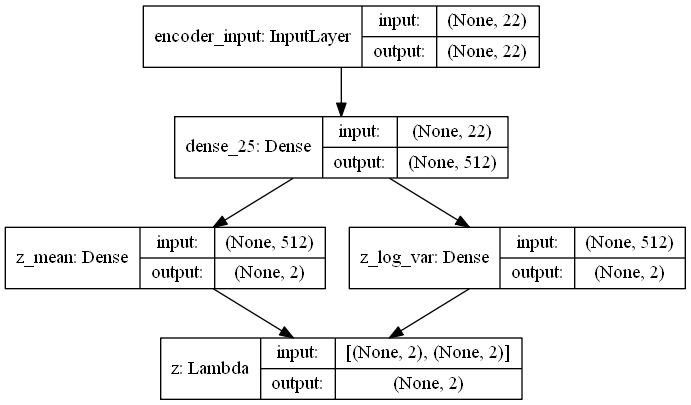

In [80]:
# network parameters
input_shape = (22,) #(original_dim, )
original_dim = 22
intermediate_dim = 512
batch_size = 10
latent_dim = 2
epochs = 50

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input') # 784
x = Dense(intermediate_dim, activation='relu')(inputs) # 512
z_mean = Dense(latent_dim, name='z_mean')(x) # 2
z_log_var = Dense(latent_dim, name='z_log_var')(x) # 2
 
# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend

z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 2)                 0         
_________________________________________________________________
dense_26 (Dense)             (None, 512)               1536      
_________________________________________________________________
dense_27 (Dense)             (None, 22)                11286     
Total params: 12,822
Trainable params: 12,822
Non-trainable params: 0
_________________________________________________________________


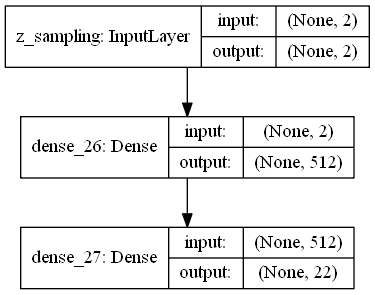

In [81]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling') # 2
x = Dense(intermediate_dim, activation='relu')(latent_inputs) # 152
outputs = Dense(original_dim, activation='sigmoid')(x) # 784

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

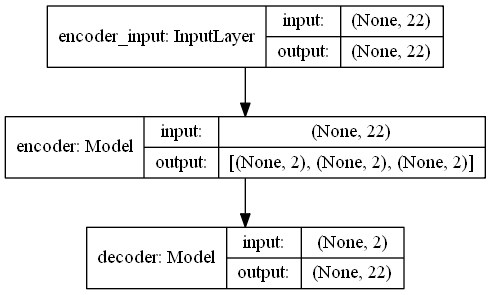

In [82]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')
plot_model(vae, show_shapes= True)

In [83]:
outputs.shape

TensorShape([Dimension(None), Dimension(22)])

C:\Users\Rajat\Anaconda3\lib\site-packages\keras\engine\training_utils.py:819: UserWarning: Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.
  'be expecting any data to be passed to {0}.'.format(name))


Model: "vae_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 22)                0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 13828     
_________________________________________________________________
decoder (Model)              (None, 22)                12822     
Total params: 26,650
Trainable params: 26,650
Non-trainable params: 0
_________________________________________________________________
Train on 380 samples, validate on 95 samples
Epoch 1/50
380/380 [==============================] - ETA: 59s - loss: na - ETA: 2s - loss: na - ETA: 0s - loss: n - 2s 5ms/step - loss: nan - val_loss: nan
Epoch 2/50
380/380 [==============================] - ETA: 0s - loss: n - ETA: 0s - loss: n - ETA: 0s - loss: n - ETA: 0s - loss: n - 0s 527us/step - loss: nan - val_loss: nan
Epoch 3

Epoch 43/50
380/380 [==============================] - ETA: 0s - loss: n - ETA: 0s - loss: n - ETA: 0s - loss: n - ETA: 0s - loss: n - 0s 532us/step - loss: nan - val_loss: nan
Epoch 44/50
380/380 [==============================] - ETA: 0s - loss: n - ETA: 0s - loss: n - ETA: 0s - loss: n - ETA: 0s - loss: n - 0s 535us/step - loss: nan - val_loss: nan
Epoch 45/50
380/380 [==============================] - ETA: 0s - loss: n - ETA: 0s - loss: n - ETA: 0s - loss: n - ETA: 0s - loss: n - 0s 495us/step - loss: nan - val_loss: nan
Epoch 46/50
380/380 [==============================] - ETA: 0s - loss: n - ETA: 0s - loss: n - ETA: 0s - loss: n - 0s 471us/step - loss: nan - val_loss: nan
Epoch 47/50
380/380 [==============================] - ETA: 0s - loss: n - ETA: 0s - loss: n - ETA: 0s - loss: n - ETA: 0s - loss: n - 0s 492us/step - loss: nan - val_loss: nan
Epoch 48/50
380/380 [==============================] - ETA: 0s - loss: n - ETA: 0s - loss: n - ETA: 0s - loss: n - ETA: 0s - loss: n - 

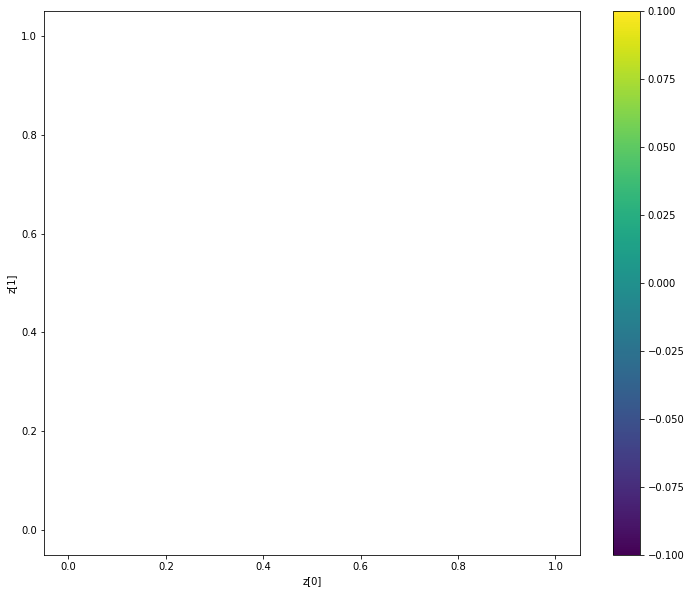

In [92]:
# parser = argparse.ArgumentParser()
# help_ = "Load h5 model trained weights"
# parser.add_argument("-w", "--weights", help=help_)
# help_ = "Use mse loss instead of binary cross entropy (default)"
# parser.add_argument("-m",
#                    "--mse",
#                    help=help_, action='store_true')
# args = parser.parse_args()
models = (encoder, decoder)
data = (x_test, y_test)

# VAE loss = mse_loss or xent_loss + kl_loss

#if args.mse:
if 0:
    reconstruction_loss = mse(inputs, outputs)
else:
    reconstruction_loss = binary_crossentropy(inputs,
                                              outputs)

reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()
plot_model(vae,
           to_file='vae_mlp.png',
           show_shapes=True)

# if args.weights:
#     vae.load_weights(args.weights)
# else:
    # train the autoencoder
vae.fit(x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))
vae.save_weights('vae_mlp_mnist.h5')

plot_results(models,
             data,
             batch_size=batch_size,
             model_name="vae_mlp")

In [88]:
inputs.shape

TensorShape([Dimension(None), Dimension(22)])

In [89]:
outputs.shape

TensorShape([Dimension(None), Dimension(22)])